In [2]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 5000)

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15,11)
import seaborn as sns

import os

filepath = os.path.expanduser('~/Documents/data/nfl-big-data-bowl-2022/')



# get data
players = pd.read_csv(filepath + 'players.csv')
plays = pd.read_csv(filepath + 'plays.csv')
scouting = pd.read_csv(filepath + 'PFFScoutingData.csv')

TOC
* [Adding the plays data](#adding-plays)
* [Adding number of returns, kicks, and blocks](#adding-number-cols)
* [Part 1: Punters](#punters)
* * Punters dataset includes the number of punts, ratio of normal punts (as opposed to Aussie-style), ratios of how the ball lands, ratio of punts going the intended direction, average and maximum hang times
* [Part 2: Kickers](#kickers)
* * Kickers dataset includes number of kickoffs and field goals, mean and max kickoff distance, mean and max kickoff hangtime, ratio of kicks going the intended direction, ratio of touchbacks, ratio of kicks that go Out of Bounds, ratio of onside kicks (to normal kicks), recovery rate of those onside kicks, mean and max distance of succesful field goals, mean, minimum and max distance of missed field goals, as well as the number of kicks made and missed in the clutch - to take the lead or tie with under 3 minutes to play
* [Part 3: Returners](#returners)


<a id='top'></a>

# Augmenting the NFL players special teams dataset
In this notebook, I'm going to be using the data provided in the NFL big data bowl to add a ton of features to the special teams dataset. This is currently a work-in-progress but I'll upload versions of the dataset(s) to kaggle as I go.

The current version (first one) splits the players into 3 - punters, kickers, and returners - and simply has the number of kicks, punts, whatever-they-do as an extra column. I'm planning next on connecting it with the tracking and scouting data to get some more interesting fields.

For the moment, the dataset contains several self-evident fields:
* Player's NFL ID, a unique identifier;
* Height, Weight, Birthdate;
* Their college;
* Their (non special teams) position;
* Their name.

Right off the bat, we can get some information. For example, a look at the players by college:

In [3]:
top25_colleges = players.groupby('collegeName').count().sort_values(by='nflId', ascending=False)['nflId'].head(25)

<AxesSubplot:xlabel='collegeName'>

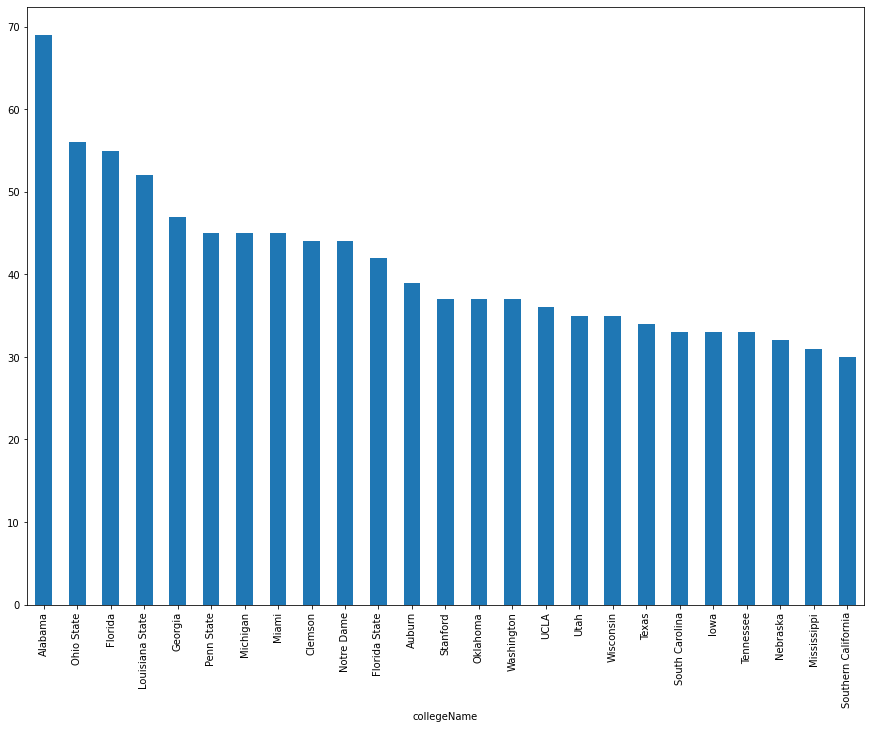

In [4]:
# barchart of player colleges
top25_colleges.plot(kind='bar')

And by position:

<AxesSubplot:xlabel='Position'>

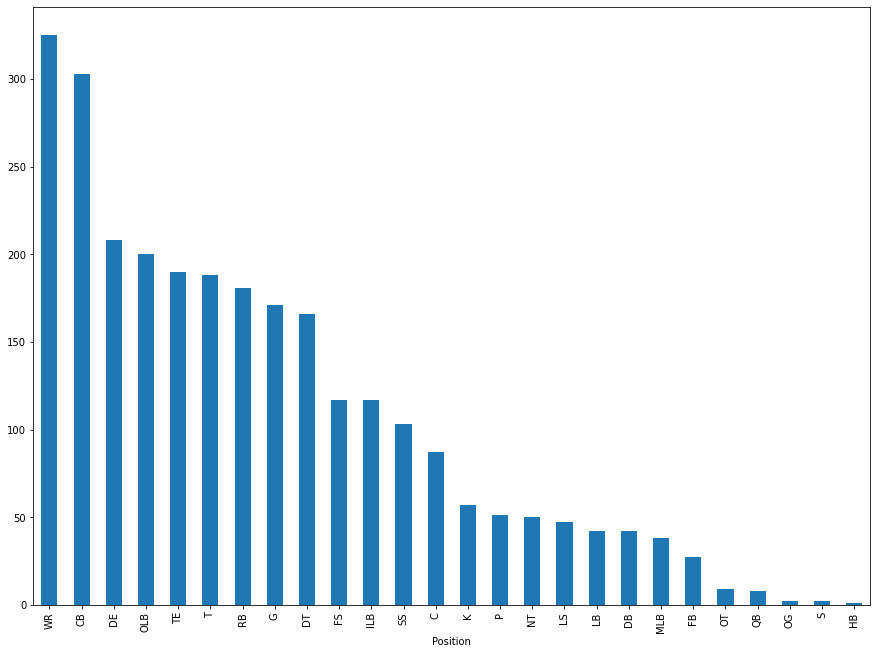

In [7]:
positions = players.groupby('Position').count().sort_values(by='nflId', ascending=False)['nflId']

# barchart of positions
positions.plot(kind='bar')

The purpose of this notebook will be to combine much of the other data supplied by the NFL into a new players dataset to facilitate this kind of analysis. 

### Bringing in plays data
[Return to top](#top)

<a id="adding-plays"></a>

The plays data will be the first thing I'm going to use to add the number of each type of play that each players was involved with. 

* First, the kickerId column needs to be adjusted so that I can differentiate between a punt, kickoff and field goal;
* Second, the returner column poses a slight problem for plays where there was a lateral involved. This will be handled in [Part 4: returners](id='returners');

In [12]:
plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,NaN,NaN,PHI,35,15:00:00,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,NaN,NaN,PHI,3,05:03:00,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,44979,NaN,ATL,35,05:01:00,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,NaN,NaN,PHI,35,00:33:00,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,2021010315,3683,J.Myers kicks 65 yards from SEA 35 to end zone...,4,0,0,SEA,Kickoff,Touchback,41175.0,NaN,NaN,SEA,35,02:20:00,NaN,NaN,NaN,16,19,NaN,75.0,NaN,40,75
19975,2021010315,3870,"J.Myers extra point is GOOD, Center-T.Ott, Hol...",4,0,0,SEA,Extra Point,Kick Attempt Good,41175.0,NaN,NaN,SF,15,01:49:00,NaN,NaN,NaN,16,25,NaN,NaN,NaN,0,25
19976,2021010315,3886,J.Myers kicks 65 yards from SEA 35 to end zone...,4,0,0,SEA,Kickoff,Touchback,41175.0,NaN,NaN,SEA,35,01:49:00,NaN,NaN,NaN,16,26,NaN,75.0,NaN,40,75
19977,2021010315,4166,"T.Vizcaino extra point is GOOD, Center-C.Holba...",4,0,0,SF,Extra Point,Kick Attempt Good,47590.0,NaN,NaN,SEA,15,00:23:00,NaN,NaN,NaN,22,26,NaN,NaN,NaN,0,95


In [8]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19979 entries, 0 to 19978
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  19979 non-null  int64  
 1   playId                  19979 non-null  int64  
 2   playDescription         19979 non-null  object 
 3   quarter                 19979 non-null  int64  
 4   down                    19979 non-null  int64  
 5   yardsToGo               19979 non-null  int64  
 6   possessionTeam          19979 non-null  object 
 7   specialTeamsPlayType    19979 non-null  object 
 8   specialTeamsResult      19979 non-null  object 
 9   kickerId                19878 non-null  float64
 10  returnerId              6938 non-null   object 
 11  kickBlockerId           100 non-null    float64
 12  yardlineSide            19813 non-null  object 
 13  yardlineNumber          19979 non-null  int64  
 14  gameClock               19979 non-null

Splitting kickoffs, punts and field goals - I'll make a new dataframe with only some relevant info and then adjust it so that instead of a single kickerId column, it'll be punter, kickoff kicker, or fg kicker. 

In [6]:
kick_plays = plays.loc[plays['specialTeamsPlayType'].isin(['Kickoff', 'Punt', "Field Goal"])]
kick_plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,NaN,NaN,PHI,35,15:00:00,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,NaN,NaN,PHI,3,05:03:00,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,44979,NaN,ATL,35,05:01:00,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,NaN,NaN,PHI,35,00:33:00,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,2021010315,3105,J.Myers kicks 63 yards from SEA 35 to SF 2. A....,4,0,0,SEA,Kickoff,Return,41175.0,48322,NaN,SEA,35,10:54:00,NaN,NaN,NaN,16,12,NaN,63.0,18.0,45,75
19972,2021010315,3258,"(7:52) M.Wishnowsky punts 44 yards to SEA 15, ...",4,4,5,SF,Punt,Fair Catch,47893.0,46211,NaN,SF,41,07:52:00,NaN,NaN,NaN,16,12,NaN,44.0,NaN,44,51
19974,2021010315,3683,J.Myers kicks 65 yards from SEA 35 to end zone...,4,0,0,SEA,Kickoff,Touchback,41175.0,NaN,NaN,SEA,35,02:20:00,NaN,NaN,NaN,16,19,NaN,75.0,NaN,40,75
19976,2021010315,3886,J.Myers kicks 65 yards from SEA 35 to end zone...,4,0,0,SEA,Kickoff,Touchback,41175.0,NaN,NaN,SEA,35,01:49:00,NaN,NaN,NaN,16,26,NaN,75.0,NaN,40,75


In [9]:
# drop unecessary fields
kick_plays = kick_plays.drop(['playDescription',
                              'quarter','down',	'yardsToGo','possessionTeam',
                              'specialTeamsResult', 'yardlineSide','yardlineNumber',
                              'gameClock',	'penaltyCodes',	'penaltyJerseyNumbers',
                              'penaltyYards','preSnapHomeScore', 'preSnapVisitorScore','passResult',
                              'kickLength','kickReturnYardage', 'playResult','absoluteYardlineNumber'],
                             axis=1)

# add the new columns
kick_plays['ko_kickerId'] = np.nan
kick_plays['fg_kickerId'] = np.nan
kick_plays['punterId'] = np.nan

# fill the new columns 
for row in kick_plays.itertuples():
    if row.specialTeamsPlayType == "Kickoff":
        kick_plays.at[row.Index,'ko_kickerId'] = kick_plays.at[row.Index,'kickerId']
    elif row.specialTeamsPlayType == "Punt":
        kick_plays.at[row.Index,'punterId'] = kick_plays.at[row.Index,'kickerId']
    elif row.specialTeamsPlayType == "Field Goal":
        kick_plays.at[row.Index,'fg_kickerId'] = kick_plays.at[row.Index,'kickerId']
        
kick_plays

,gameId,playId,specialTeamsPlayType,kickerId,returnerId,kickBlockerId,ko_kickerId,fg_kickerId,punterId
0,2018090600,37,Kickoff,44966.0,NaN,NaN,44966.0,NaN,NaN
1,2018090600,366,Punt,45603.0,42450,NaN,NaN,NaN,45603.0
2,2018090600,658,Field Goal,27091.0,NaN,NaN,NaN,27091.0,NaN
3,2018090600,677,Kickoff,37267.0,44979,NaN,37267.0,NaN,NaN
4,2018090600,872,Punt,45603.0,NaN,NaN,NaN,NaN,45603.0
...,...,...,...,...,...,...,...,...,...
19971,2021010315,3105,Kickoff,41175.0,48322,NaN,41175.0,NaN,NaN
19972,2021010315,3258,Punt,47893.0,46211,NaN,NaN,NaN,47893.0
19974,2021010315,3683,Kickoff,41175.0,NaN,NaN,41175.0,NaN,NaN
19976,2021010315,3886,Kickoff,41175.0,NaN,NaN,41175.0,NaN,NaN


This is a function for adding in the number of each type of play. Note that under this version, it doesn't yet handle the returner column well where laterals are involved.

In [11]:
def merge_play_counts(players_df, plays_df, col):
    """A function to add the number of kicks, kick blocks, and returns to a column
       Note: for now, it just drops the returners (by index) who pose the lateral problem
       Those players will be manually added back below """
    df = players_df.copy()
    
    # handling the returners
    # for now this drops the problematic ones, to be added back and dealt with
    if col == 'returnerId':
        plays_df = plays_df.drop([1753, 2394,5107,6688,11195,12503,16750,16928,16937,19367,19883])
        plays_df[col] = pd.to_numeric(plays_df[col])
        
    # get the number of whatever col I'm looking for into a temp df
    temp = pd.DataFrame(plays_df[col].value_counts())
    temp = temp.reset_index().rename(columns={col: f'num_{col[:-4]}s', 'index':'nflId'})
    
    # left join the temp df to the main one
    df = pd.merge(df, temp, how='left', on='nflId')
    
    # fill the nan's with 0's
    df[f'num_{col[:-4]}s'].fillna(value=0, inplace=True)
    
    return df
    

<a id="punters"></a>
## Part 1: Punters

[Return to top](#top)



In [24]:
# get the number of punts
num_punts = plays[plays['specialTeamsPlayType']=='Punt']['kickerId'].value_counts().reset_index().rename(columns={'kickerId': 'num_punts', 'index':'nflId'})

# merge with the punters dataframe
punters = pd.merge(punters, num_punts, how='left',on='nflId')

In [25]:
punters.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName,num_punts
0,45296,6-0,205,1994-07-25,Arizona State,P,Matt Haack,214.0
1,46903,6-0,208,1996-09-13,New Mexico,P,Corey Bojorquez,161.0
2,53146,6-5,190,1997-04-07,South Carolina,P,Joseph Charlton,43.0
3,34615,6-4,235,1986-03-08,Southern Methodist,P,Thomas Morstead,156.0
4,41420,6-4,212,1991-02-22,Miami,P,Pat O'Donnell,196.0


<AxesSubplot:xlabel='displayName'>

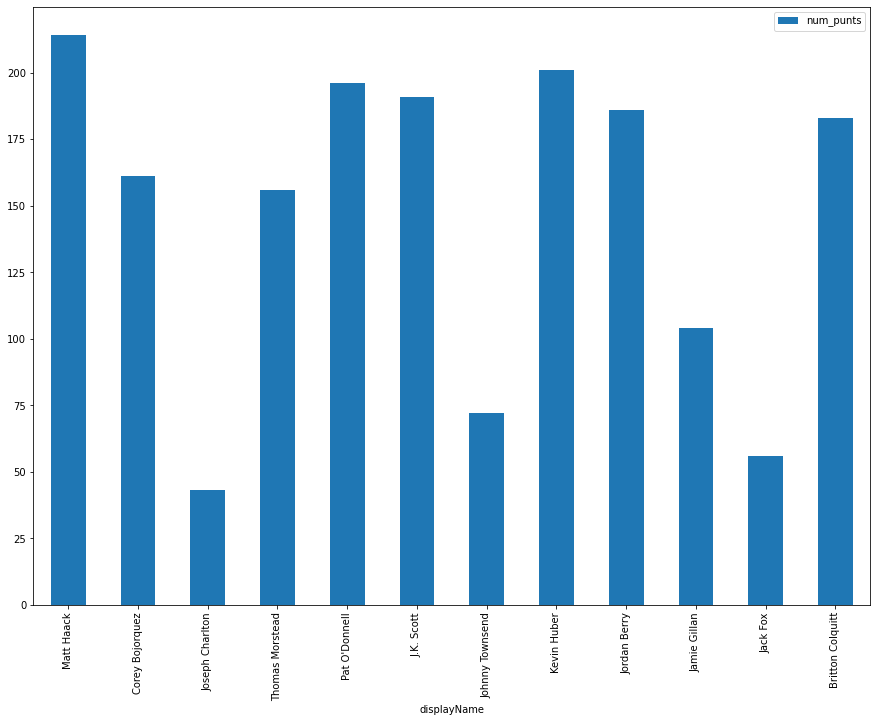

In [26]:
# plotting the punters that happen to be in those first 12, completely arbitrary
punters.head(12).plot.bar(x='displayName', y='num_punts')

### Scouting data
In the scouting data, first we need to get the plays for kickoffs and punts.

In [27]:
scouting.head()

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType
0,2018090600,37,NaN,NaN,NaN,3.85,D,R,R,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,PHI 23; PHI 27,NaN,NaN
1,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC
2,2018090600,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI 58,NaN,NaN
3,2018090600,677,NaN,NaN,NaN,4.06,D,R,R,C,C,ATL 83,ATL 22,ATL 27,8-0-2,NaN,NaN,ATL 17; ATL 22,NaN,NaN
4,2018090600,872,OK,0.84,2.00,4.35,N,C,L,NaN,NaN,NaN,NaN,NaN,NaN,PHI 18; PHI 29,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF


First, I need to get the plays referring to punts. From the [competition page](https://www.kaggle.com/c/nfl-big-data-bowl-2022/data), there are three values in the kickType field that refer to punts: N, normal punts; A, nose-down, Aussie style punts; R, Rugby-style punts.

In [15]:
# getting number of each type of kick
scouting['kickType'].value_counts()

D    6944
N    4095
A    1781
F     319
P     226
O     155
Q     134
K      50
S      14
R       4
B       1
Name: kickType, dtype: int64

In [31]:
# dataframe of only the punts
scouting_punts = scouting[scouting['kickType'].isin(['N','A','R'])]

# dropping some unnecessary fields
scouting_punts = scouting_punts.drop(['missedTackler','assistTackler','tackler',
                                      'kickoffReturnFormation','gunners','puntRushers',
                                      'specialTeamsSafeties','vises','returnDirectionIntended',
                                      'returnDirectionActual'], axis=1)

# the punt_map df is used to join the plays data (here only kick_plays) with the scouting data
punt_map = kick_plays[kick_plays['specialTeamsPlayType']=="Punt"].drop(['specialTeamsPlayType','kickerId','returnerId','kickBlockerId','ko_kickerId','fg_kickerId'], axis=1)
scouting_punts = scouting_punts.merge(punt_map, how='left',on=['gameId','playId'])

scouting_punts

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,kickContactType,punterId
0,2018090600,366,OK,0.84,2.12,4.46,N,C,C,CC,45603.0
1,2018090600,872,OK,0.84,2.00,4.35,N,C,L,BF,45603.0
2,2018090600,973,OK,0.86,2.19,4.98,N,L,L,CC,37267.0
3,2018090600,1850,OK,0.81,2.00,4.53,N,R,R,BB,45603.0
4,2018090600,1989,OK,0.76,2.12,4.62,N,C,C,CC,37267.0
...,...,...,...,...,...,...,...,...,...,...,...
5875,2021010315,1359,H,0.92,2.23,4.50,N,L,L,CC,47893.0
5876,2021010315,1479,OK,0.79,2.07,4.80,N,R,R,CC,46218.0
5877,2021010315,2235,OK,0.79,2.08,3.36,N,C,C,CC,46218.0
5878,2021010315,2497,OK,0.75,1.99,4.69,N,C,C,CC,46218.0


Adding in some useful fields:

In [29]:
# adding a column for punts that went the correct direction
scouting_punts['kickDirectionCorrect'] = scouting_punts['kickDirectionIntended']==scouting_punts['kickDirectionActual']

# removing the direction columns that are now useless
scouting_punts = scouting_punts.drop(['kickDirectionIntended','kickDirectionActual'], axis=1)

Check if the number of punts for each punter in the scouting data matches the number from the plays data:

In [30]:
# counts records in the scouting data per punter
# renames the columns for matching
# merges with punter df 
punt_count_compare = pd.DataFrame(scouting_punts['punterId'].value_counts()).reset_index().rename(columns={'index':'nflId','punterId':'scouting_num_punts'}).merge(punters[['nflId','num_punts']], how='inner')

# adds a column to compare the numbers
punt_count_compare['difference'] = punt_count_compare['num_punts'] - punt_count_compare['scouting_num_punts']

#punt_count_compare.sort_values('difference', ascending=False)

There are slight differences between the two datasets, however they are very small, so I'm going to leave it for the time being. First, I'll add up the categorical columns to get numbers for each punter.

Regarding how the punts were fielded, the following is taken directly from the [data page](#https://www.kaggle.com/c/nfl-big-data-bowl-2022/data):

kickContactType: Detail on how a punt was fielded, or what happened when it wasn't fielded (text).
Possible values:
* BB: Bounced Backwards
* BC: Bobbled Catch from Air
* BF: Bounced Forwards
* BOG: Bobbled on Ground
* CC: Clean Catch from Air
* CFFG: Clean Field From Ground
* DEZ: Direct to Endzone
* ICC: Incidental Coverage Team Contact
* KTB: Kick Team Knocked Back
* KTC: Kick Team Catch
* KTF: Kick Team Knocked Forward
* MBC: Muffed by Contact with Non-Designated Returner
* MBDR: Muffed by Designated Returner
* OOB: Directly Out Of Bounds

I'll seperate those into five: Caught, Ground, Kick Team Touched first, Out of Bounds, Out of Endzone

In [19]:
# view the number of each of the categorical punts
punters_summed_dummy_columns = pd.get_dummies(scouting_punts, columns=['kickType','kickContactType','kickDirectionCorrect']).groupby(['punterId']).sum()

# styles of punting
punting_styles = punters_summed_dummy_columns[['kickType_A','kickType_N','kickType_R']]
punting_styles['normalPuntRatio'] = punting_styles['kickType_N']/(punting_styles['kickType_A'] + punting_styles['kickType_N'] + punting_styles['kickType_R'])
punting_styles = punting_styles.reset_index()
punting_styles['nflId'] = punting_styles['punterId'] 
punting_styles = punting_styles.drop(['kickType_A','kickType_N','kickType_R','punterId'], axis=1)


# punts fielded
punts_fielded = punters_summed_dummy_columns[['kickContactType_BB','kickContactType_BC','kickContactType_BF',
                                              'kickContactType_BOG','kickContactType_CC','kickContactType_CFFG',
                                              'kickContactType_DEZ','kickContactType_ICC','kickContactType_KTB',
                                              'kickContactType_KTC','kickContactType_KTF','kickContactType_MBC',
                                              'kickContactType_MBDR','kickContactType_OOB']]
punts_fielded_sum = punts_fielded['kickContactType_BB'] + punts_fielded['kickContactType_BC'] + punts_fielded['kickContactType_BF'] + punts_fielded['kickContactType_BOG'] + punts_fielded['kickContactType_CC'] + punts_fielded['kickContactType_CFFG'] + punts_fielded['kickContactType_DEZ'] + punts_fielded['kickContactType_ICC'] + punts_fielded['kickContactType_KTB'] + punts_fielded['kickContactType_KTC'] + punts_fielded['kickContactType_KTF'] + punts_fielded['kickContactType_MBC'] + punts_fielded['kickContactType_MBDR'] + punts_fielded['kickContactType_OOB']
punts_fielded['caughtRatio'] = (punts_fielded['kickContactType_BC'] + punts_fielded['kickContactType_CC'])/punts_fielded_sum
punts_fielded['groundRatio'] = (punts_fielded['kickContactType_BB'] + punts_fielded['kickContactType_BOG'] + punts_fielded['kickContactType_CFFG'])/punts_fielded_sum
punts_fielded['kickTeamTouchedFirstRatio'] = (punts_fielded['kickContactType_KTB'] + punts_fielded['kickContactType_KTF'] + punts_fielded['kickContactType_KTC'])/punts_fielded_sum
punts_fielded['outOfBoundsRatio'] = punts_fielded['kickContactType_OOB']/punts_fielded_sum
punts_fielded['outOfEZRatio'] = punts_fielded['kickContactType_DEZ']/punts_fielded_sum
punts_fielded = punts_fielded.reset_index()
punts_fielded['nflId'] = punts_fielded['punterId']
punts_fielded = punts_fielded.drop(['kickContactType_BB','kickContactType_BC','kickContactType_BF',
                                              'kickContactType_BOG','kickContactType_CC','kickContactType_CFFG',
                                              'kickContactType_DEZ','kickContactType_ICC','kickContactType_KTB',
                                              'kickContactType_KTC','kickContactType_KTF','kickContactType_MBC',
                                              'kickContactType_MBDR','kickContactType_OOB','punterId'], axis=1)


# kick direction intended
punts_kick_direction_intended = punters_summed_dummy_columns[['kickDirectionCorrect_True','kickDirectionCorrect_False']]
punts_kick_direction_intended['intendedDirectionRatio'] = punts_kick_direction_intended['kickDirectionCorrect_True']/(punts_kick_direction_intended['kickDirectionCorrect_True']+punts_kick_direction_intended['kickDirectionCorrect_False'])
punts_kick_direction_intended = punts_kick_direction_intended.reset_index()
punts_kick_direction_intended['nflId'] = punts_kick_direction_intended['punterId']
punts_kick_direction_intended = punts_kick_direction_intended.drop(['punterId','kickDirectionCorrect_True','kickDirectionCorrect_False'], axis=1)

In [20]:
# merge those dataframes to the main punters dataset
punters = punters.merge(punting_styles, on='nflId')
punters = punters.merge(punts_fielded, on='nflId')
punters = punters.merge(punts_kick_direction_intended, on='nflId')

Next up, I want to get the mean and max hangtimes for each punter (hangtime refers to how long the ball stays in the air).

In [21]:
# drop unecessary columns
punt_hts = scouting_punts.drop(['gameId','playId','snapDetail','snapTime','operationTime','kickType','kickContactType','kickDirectionCorrect'], axis=1)

# calculate mean and max ht by punter
punt_hts = punt_hts.groupby('punterId').agg(meanHangTime = ('hangTime','mean'),maxHangTime = ('hangTime','max')).reset_index()
punt_hts = punt_hts.rename(columns={'punterId':'nflId'})

# join it to the main set
punters = punters.merge(punt_hts, on='nflId')

In [22]:
punters.sort_values('meanHangTime', ascending=False).head()

,nflId,height,weight,birthDate,collegeName,Position,displayName,num_punts,normalPuntRatio,caughtRatio,groundRatio,kickTeamTouchedFirstRatio,outOfBoundsRatio,outOfEZRatio,intendedDirectionRatio,meanHangTime,maxHangTime
2,53146,6-5,190,1997-04-07,South Carolina,P,Joseph Charlton,43.0,0.697674,0.697674,0.000000,0.000000,0.046512,0.046512,1.000000,4.544419,5.30
10,48258,6-2,224,1996-09-01,Rice,P,Jack Fox,56.0,0.767857,0.607143,0.107143,0.000000,0.017857,0.035714,0.982143,4.541964,5.43
5,46241,6-6,208,1995-10-30,Alabama,P,J.K. Scott,191.0,0.793651,0.608466,0.079365,0.005291,0.068783,0.010582,0.978836,4.511481,5.52
17,50975,6-5,243,NaN,NaN,P,Hunter Niswander,20.0,0.950000,0.900000,0.000000,0.000000,0.000000,0.000000,1.000000,4.503000,5.07
43,37267,72,208,1987-10-18,Miami (Fla.),P,Matt Bosher,71.0,0.764706,0.750000,0.058824,0.000000,0.000000,0.000000,0.882353,4.478529,5.30


In [23]:
def get_top_five(df, column):
    return df.sort_values(column, ascending=False)[['displayName', 'num_punts',column]].head()

Brett Kern put 15% of his punts out of bounds!

In [24]:
get_top_five(punters, 'outOfBoundsRatio')

,displayName,num_punts,outOfBoundsRatio
25,Brett Kern,184.0,0.153005
1,Corey Bojorquez,161.0,0.113208
14,Jake Bailey,125.0,0.104000
39,Colby Wadman,133.0,0.097744
31,Michael Dickson,195.0,0.082474


Feel free to take this in csv if you'd like:

In [25]:
punters.to_csv('punters.csv')

<a id='kickers'></a>
## Part 2: Kickers

[Return to Top](#top)

In [26]:
# isolate kickers
kickers = players[players["Position"]=="K"]

# get the proper id's
kickers = merge_play_counts(kickers, kick_plays, 'ko_kickerId')
kickers = merge_play_counts(kickers, kick_plays, 'fg_kickerId')

kickers

,nflId,height,weight,birthDate,collegeName,Position,displayName,num_ko_kicks,num_fg_kicks
0,46298,5-11,186,1995-11-16,New Mexico,K,Jason Sanders,227.0,83
1,52596,5-10,185,1997-02-14,Georgia Southern,K,Tyler Bass,100.0,28
2,43689,5-11,184,1994-07-07,Georgia State,K,Wil Lutz,286.0,86
3,48337,5-11,213,1996-04-10,Virginia Tech,K,Joey Slye,151.0,55
4,32386,6-1,207,1984-09-03,Colorado,K,Mason Crosby,243.0,71
5,41991,5-8,160,1991-11-18,Tulane,K,Cairo Santos,155.0,51
6,47953,5-9,214,1996-11-15,Oklahoma,K,Austin Seibert,95.0,34
7,39470,6-1,183,1989-11-21,Texas,K,Justin Tucker,293.0,94
8,41688,6-0,190,1992-02-19,Auburn,K,Cody Parkey,180.0,54
9,48329,6-0,179,03/22/1996,Central Florida,K,Matthew Wright,15.0,4


<AxesSubplot:xlabel='displayName'>

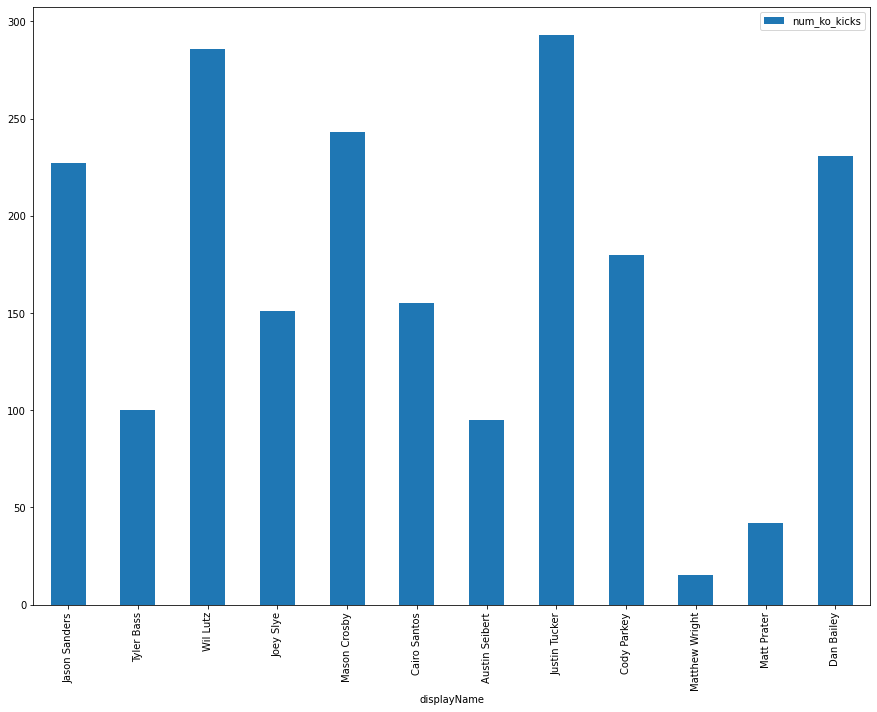

In [27]:
kickers.head(12).plot.bar(x='displayName', y='num_ko_kicks')

<a id='kickoffs'></a>
### Part 2a, Kickoffs
What I want to look at:
* Deep kick average distance
* Touchback ratio
* OOB ratio
* Onside ratio
* Intended vs Actual Directions

In [28]:
# get kickoffs from the plays df
kickoffs = plays[plays['specialTeamsPlayType'] == 'Kickoff']

# drop unecessary columns
kickoffs = kickoffs.drop(['playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'specialTeamsPlayType',
       'kickBlockerId', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers',
       'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',],axis=1)

kickoffs.head()

,gameId,playId,specialTeamsResult,kickerId,returnerId,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,Touchback,44966.0,NaN,66.0,NaN,40,45
3,2018090600,677,Return,37267.0,44979,64.0,30.0,34,75
7,2018090600,1387,Touchback,44966.0,NaN,72.0,NaN,40,75
9,2018090600,1606,Return,37267.0,44979,68.0,13.0,60,45
12,2018090600,2225,Touchback,37267.0,NaN,71.0,NaN,40,45


In [29]:
# getting number of each type of kick
scouting['kickType'].value_counts()

D    6944
N    4095
A    1781
F     319
P     226
O     155
Q     134
K      50
S      14
R       4
B       1
Name: kickType, dtype: int64

In the scouting data, possible values for kickoff plays:

* D: Deep - your normal deep kick with decent hang time
* F: Flat - different than a Squib in that it will have some hang time and no roll but has a lower trajectory and hang time than a Deep kick off
* K: Free Kick - Kick after a safety
* O: Obvious Onside - score and situation dictates the need to regain possession. Also the hands team is on for the returning team
* P: Pooch kick - high for hangtime but not a lot of distance - usually targeting an upman
* Q: Squib - low-line drive kick that bounces or rolls considerably, with virtually no hang time
* S: Surprise Onside - accounting for score and situation an onsides kick that the returning team doesn’t expect. Hands teams probably aren't on the field
* B: Deep Direct OOB - Kickoff that is aimed deep (regular kickoff) that goes OOB directly (doesn't bounce)


In [30]:
# dataframe of only the kickoffs
scouting_kos = scouting[scouting['kickType'].isin(['D','F','K','O','P','Q','S','B'])]

scouting_kos['kickDirectionCorrect'] = scouting_kos['kickDirectionIntended']==scouting_kos['kickDirectionActual']

# drop unecessary columns
scouting_kos = scouting_kos.drop(['snapDetail','snapTime','operationTime',
                                  'kickDirectionIntended','kickDirectionActual',
                                  'missedTackler','assistTackler','tackler',
                                  'gunners','puntRushers','vises',
                                  'specialTeamsSafeties','kickContactType',
                                  'kickoffReturnFormation'], axis=1)

# join with the plays df
kos = scouting_kos.merge(kickoffs, on=['gameId','playId'])

kos.head()

,gameId,playId,hangTime,kickType,returnDirectionIntended,returnDirectionActual,kickDirectionCorrect,specialTeamsResult,kickerId,returnerId,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,3.85,D,NaN,NaN,True,Touchback,44966.0,NaN,66.0,NaN,40,45
1,2018090600,677,4.06,D,C,C,True,Return,37267.0,44979,64.0,30.0,34,75
2,2018090600,1387,4.09,D,NaN,NaN,True,Touchback,44966.0,NaN,72.0,NaN,40,75
3,2018090600,1606,3.63,D,C,R,True,Return,37267.0,44979,68.0,13.0,60,45
4,2018090600,2225,3.98,D,NaN,NaN,True,Touchback,37267.0,NaN,71.0,NaN,40,45


Getting deep kickoff average distance:

In [31]:
# calculating the mean and max kickoff distances and hangtimes on deep kicks
deep_kos = kos[kos['kickType']=='D']
deep_kos = deep_kos.groupby('kickerId').agg(meanKickoffDistance=('kickLength','mean'),
                                            maxKickoffDistance=('kickLength','max'),
                                            meanKickoffHangtime=('hangTime','mean'),
                                            maxKickoffHantime=('hangTime','max')).reset_index().rename(columns={'kickerId':'nflId'})
# join it to the main set
kickers = kickers.merge(deep_kos, on='nflId', how='left')

In [32]:
kos[kos['kickType']=='D']['specialTeamsResult'].value_counts()

Touchback        4580
Return           2309
Muffed             34
Out of Bounds      21
Name: specialTeamsResult, dtype: int64

In [33]:
# view the number of each of the categorical punts
# it's going to sum up the gameId's, playId's, hangtimes, etc over each player as well, which is obviously nonsensical, but I'm not using these so it doesn't matter in this context
# those will get dropped from the df before it is merged with the kickers df
kickers_summed_dummy_columns = pd.get_dummies(kos, columns=['kickType','specialTeamsResult','kickDirectionCorrect']).groupby(['kickerId']).sum()

# column for the number of kicks
kickers_summed_dummy_columns['numKickoffs'] = kickers_summed_dummy_columns['kickType_B'] + kickers_summed_dummy_columns['kickType_D'] + kickers_summed_dummy_columns['kickType_F'] + kickers_summed_dummy_columns['kickType_K'] + kickers_summed_dummy_columns['kickType_O'] + kickers_summed_dummy_columns['kickType_P'] + kickers_summed_dummy_columns['kickType_Q'] + kickers_summed_dummy_columns['kickType_S'] 

# direction intended
kickers_summed_dummy_columns['intendedDirectionRatio'] = kickers_summed_dummy_columns['kickDirectionCorrect_True']/(kickers_summed_dummy_columns['kickDirectionCorrect_True']+kickers_summed_dummy_columns['kickDirectionCorrect_False'])

# calculate touchback ratio on deep kicks 
kickers_summed_dummy_columns['touchbackRatio'] = kickers_summed_dummy_columns['specialTeamsResult_Touchback']/kickers_summed_dummy_columns['kickType_D']

# calculate out of bounds ratio
kickers_summed_dummy_columns['OOBRatio'] = kickers_summed_dummy_columns['kickType_B']/kickers_summed_dummy_columns['numKickoffs']

# calculate onside ratio and recovery rate
kickers_summed_dummy_columns['onsideRatio'] = kickers_summed_dummy_columns['kickType_O']/kickers_summed_dummy_columns['numKickoffs']
kickers_summed_dummy_columns['onsideRecoveryRate'] = kickers_summed_dummy_columns['specialTeamsResult_Kickoff Team Recovery']/kickers_summed_dummy_columns['kickType_O']

# fix the df for joining
kickers_summed_dummy_columns = kickers_summed_dummy_columns.reset_index().rename(columns={'kickerId':'nflId'})
kickers_summed_dummy_columns = kickers_summed_dummy_columns.drop(kickers_summed_dummy_columns.columns[[x for x in range(1,26)]], axis=1)

# join the new stats columns to the main kickers df
kickers = kickers.merge(kickers_summed_dummy_columns, on='nflId')

In [34]:
kickers.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName,num_ko_kicks,num_fg_kicks,meanKickoffDistance,maxKickoffDistance,meanKickoffHangtime,maxKickoffHantime,intendedDirectionRatio,touchbackRatio,OOBRatio,onsideRatio,onsideRecoveryRate
0,46298,5-11,186,1995-11-16,New Mexico,K,Jason Sanders,227.0,83,70.974619,80.0,4.085838,4.91,0.995595,0.837563,0.0,0.026432,0.166667
1,52596,5-10,185,1997-02-14,Georgia Southern,K,Tyler Bass,100.0,28,70.817204,80.0,4.072151,4.64,0.970000,0.752688,0.0,0.000000,NaN
2,43689,5-11,184,1994-07-07,Georgia State,K,Wil Lutz,286.0,86,70.833948,75.0,3.996531,4.52,0.986014,0.763838,0.0,0.006993,0.000000
3,48337,5-11,213,1996-04-10,Virginia Tech,K,Joey Slye,151.0,55,73.259259,75.0,4.032148,4.61,1.000000,1.014815,0.0,0.019868,0.000000
4,32386,6-1,207,1984-09-03,Colorado,K,Mason Crosby,243.0,71,69.288372,75.0,3.849814,4.31,0.991770,0.637209,0.0,0.012346,0.000000


<a id='field-goals'></a>
### Part 2b, Field Goals

Fields to add:
* Accuracy
* Distance
* Clutch kicks made (last two minutes of a game to win or tie)

In [35]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN


In [36]:
def encodeKickingTeamScore(df):
    if df['possessionTeam'] == df['homeTeamAbbr']:
        return df['preSnapHomeScore']
    else:
        return df['preSnapVisitorScore']
    
def encodeDefendingTeamScore(df):
    if df['possessionTeam'] == df['visitorTeamAbbr']:
        return df['preSnapHomeScore']
    else:
        return df['preSnapVisitorScore']

In [37]:
def clutchKickIndicator(df):
    """Function to apply to the df to indicate that a given kick was made in the clutch - last three minutes of the game to tie or take the lead"""
    if df['clutchKickIndicator']:
        if 0<= df['defendingTeamScore']-df['kickingTeamScore'] <= 3:
            if df['specialTeamsResult']=='Kick Attempt Good':
                return 1
            elif df['specialTeamsResult']=='Kick Attempt No Good':
                return 0
    else:
        return np.NaN

In [38]:
field_goals = plays[plays['specialTeamsPlayType'] == 'Field Goal'].drop(['playDescription', 
                                                                         'specialTeamsPlayType', 'yardlineSide','yardlineNumber',
                                                                         'returnerId', 'kickBlockerId', 'yardsToGo',
                                                                         'penaltyCodes', 'penaltyJerseyNumbers',
                                                                         'penaltyYards', 'passResult',
                                                                         'kickReturnYardage', 'playResult',
                                                                         ], axis=1)

# bring in the home and away columns from the games dataset 
field_goals = field_goals.merge(games[['gameId','homeTeamAbbr','visitorTeamAbbr']], on='gameId')

# add the clutch kick indicator
field_goals['clutchKickIndicator'] = (field_goals['gameClock'].str.slice(start=0, stop=2).isin(['02','01','00'])) & (field_goals['quarter'] == 4)

# add the more useful score columns
field_goals['kickingTeamScore'] = field_goals.apply(encodeKickingTeamScore, axis=1).astype('int64')
field_goals['defendingTeamScore'] = field_goals.apply(encodeDefendingTeamScore, axis=1).astype('int64')

# add the clutch kick made and missed for stats
field_goals['clutchKickMade'] = field_goals.apply(clutchKickIndicator, axis=1)
field_goals['clutchKickMissed'] = field_goals['clutchKickMade'] == 0

# get rid of a couple columns now made redundant
field_goals = field_goals.drop(['preSnapHomeScore','preSnapVisitorScore',], axis=1)

# mean and max kicks made
kicks_made_stats = field_goals[field_goals['specialTeamsResult'] == 'Kick Attempt Good'].groupby('kickerId').agg(meanKickLength_hit=('kickLength','mean'),
                                                                                                                 maxKickLength_hit=('kickLength','max'),
                                                                                                                 clutchKicksMade=('clutchKickMade','sum')).reset_index().rename(columns={'kickerId':'nflId'})

# mean, min and max kicks missed
kicks_missed_stats = field_goals[field_goals['specialTeamsResult'] == 'Kick Attempt No Good'].groupby('kickerId').agg(meanKickLength_missed=('kickLength','mean'),
                                                                                                                 maxKickLength_missed=('kickLength','max'),
                                                                                                                 shortestKickLength_missed=('kickLength','min'),
                                                                                                                 clutchKicksMissed=('clutchKickMissed','sum')).reset_index().rename(columns={'kickerId':'nflId'})

# finally, add these to the kickers df
kickers = kickers.merge(kicks_made_stats, on='nflId')
kickers = kickers.merge(kicks_missed_stats, on='nflId')

In [39]:
# longest kicks?
kickers.sort_values('maxKickLength_hit', ascending=False).head(12)

,nflId,height,weight,birthDate,collegeName,Position,displayName,num_ko_kicks,num_fg_kicks,meanKickoffDistance,maxKickoffDistance,meanKickoffHangtime,maxKickoffHantime,intendedDirectionRatio,touchbackRatio,OOBRatio,onsideRatio,onsideRecoveryRate,meanKickLength_hit,maxKickLength_hit,clutchKicksMade,meanKickLength_missed,maxKickLength_missed,shortestKickLength_missed,clutchKicksMissed
16,35102,6-2,202,1987-04-09,Florida State,K,Graham Gano,132.0,45,69.517544,75.0,4.065000,4.67,1.000000,0.666667,0.0,0.030303,0.000000,39.357143,63.0,1.0,47.666667,57.0,34.0,1
42,40775,6-1,185,1989-11-21,Nebraska,K,Brett Maher,143.0,62,70.038462,75.0,3.961077,4.40,1.000000,0.653846,0.0,0.027972,0.000000,36.553191,63.0,2.0,45.615385,57.0,33.0,1
29,41175,5-10,190,1991-05-12,Marist,K,Jason Myers,255.0,80,69.717949,75.0,3.988974,4.44,0.992157,0.722222,0.0,0.000000,NaN,38.780822,61.0,2.0,45.428571,58.0,30.0,1
37,43068,6-0,215,1990-11-19,Texas A&amp;M,K,Josh Lambo,99.0,57,70.367089,75.0,3.879747,4.46,1.000000,0.772152,0.0,0.070707,0.142857,37.277778,59.0,1.0,46.666667,52.0,42.0,0
12,46342,5-10,183,1995-07-28,Miami,K,Michael Badgley,68.0,62,63.362069,75.0,3.821207,4.36,1.000000,0.172414,0.0,0.000000,NaN,36.122449,59.0,2.0,48.166667,55.0,40.0,2
33,41953,6-2,185,1991-03-16,Rice,K,Chris Boswell,222.0,63,68.547739,75.0,4.029799,4.43,1.000000,0.613065,0.0,0.000000,NaN,35.127273,59.0,1.0,42.571429,54.0,32.0,1
44,41736,75,200,1991-02-26,Clemson,K,Chandler Catanzaro,65.0,19,71.442623,75.0,4.038525,4.49,0.953846,0.852459,0.0,0.000000,NaN,35.000000,59.0,0.0,40.500000,48.0,30.0,1
15,38701,6-0,191,1987-12-27,Missouri Western,K,Greg Zuerlein,240.0,93,70.931707,75.0,3.985463,4.47,1.000000,0.843902,0.0,0.008333,0.500000,37.473684,59.0,4.0,48.812500,60.0,40.0,1
9,31446,5-10,201,1984-08-10,Central Florida,K,Matt Prater,42.0,79,68.500000,75.0,4.129615,4.78,0.952381,0.692308,0.0,0.000000,inf,35.953846,59.0,2.0,48.230769,57.0,39.0,0
1,52596,5-10,185,1997-02-14,Georgia Southern,K,Tyler Bass,100.0,28,70.817204,80.0,4.072151,4.64,0.970000,0.752688,0.0,0.000000,NaN,38.909091,58.0,0.0,44.500000,61.0,34.0,0


Feel free to take this in csv if you'd like:

In [40]:
kickers.to_csv('kickers.csv')

<a id='returners'></a>
## Part 3: Returners

[Return to Top](#top)

In [41]:
returners = merge_play_counts(players, kick_plays, 'returnerId')
returners = returners[returners['num_returns'] > 0]
returners

,nflId,height,weight,birthDate,collegeName,Position,displayName,num_returns
6,44985,5-8,173,1995-04-09,Georgia,WR,Isaiah McKenzie,40.0
14,47964,5-10,190,1995-11-13,Miami,FS,Jaquan Johnson,1.0
18,52438,5-11,196,1999-11-27,Auburn,CB,Noah Igbinoghene,4.0
30,46192,6-6,260,1995-08-09,Notre Dame,TE,Durham Smythe,6.0
43,52654,5-9,190,1997-04-19,Navy,RB,Malcolm Perry,2.0
...,...,...,...,...,...,...,...,...
2698,46744,5-10,174,12/06/1992,West Georgia,WR,J.J. Jones,5.0
2704,46532,5-10,173,11/20/1993,Rutgers,WR,Janarion Grant,13.0
2722,42527,5-10,195,01/02/1992,Utah,WR,Kaelin Clay,6.0
2725,37228,5-9,188,11/08/1988,Texas Christian,WR,Jeremy Kerley,2.0


11 kicks and punts involved laterals where multiple players could be considered a returner. 

In [42]:
returns_with_laterals = plays[plays['returnerId'].str.contains(';', na=False)][['playDescription','returnerId']]
returns_with_laterals

,playDescription,returnerId
1753,G.Gano kicks 74 yards from CAR 35 to NYG -9. O...,41238;43880;43329
2394,(11:12) (Punt formation) C.Jones punts 49 yard...,44029;46130
5107,D.Bailey kicks 46 yards from MIN 35 to NE 19. ...,36473;39975
6688,R.Sanchez kicks 58 yards from IND 35 to TEN 7....,42973;46221
11195,(4:20) (Punt formation) B.Kern punts 49 yards ...,44923;45555
12503,Y.Koo kicks 34 yards from ATL 35 to SF 31. D.S...,46309;42718
16750,"(6:23) J.Berry punts 62 yards to DAL 6, Center...",46277;42094
16928,J.Scott kicks 69 yards from GB 35 to JAX -4. C...,52631;48020
16937,J.Scott kicks 60 yards from GB 35 to JAX 5. C....,52631;48020
19367,C.Santos kicks 62 yards from CHI 35 to JAX 3. ...,52737;45719


[Return to Top](#top)


In [43]:
returners.sort_values(by='num_returns', ascending=False)

,nflId,height,weight,birthDate,collegeName,Position,displayName,num_returns
1268,35527,5-11,195,1988-01-09,Citadel,WR,Andre Roberts,228.0
255,43663,6-0,195,1992-11-06,Wisconsin,WR,Alex Erickson,166.0
196,42794,5-8,190,1993-04-10,Sacramento State,WR,DeAndre Carter,137.0
112,43406,5-11,207,1995-03-07,South Carolina,WR,Pharoh Cooper,131.0
332,44978,5-10,190,1995-04-03,San Diego,WR,Jamal Agnew,123.0
...,...,...,...,...,...,...,...,...
1188,47997,5-8,200,1997-02-12,Utah State,RB,Darwin Thompson,1.0
1939,46777,6-3,205,1996-01-28,Oklahoma State,WR,Chris Lacy,1.0
1206,35446,5-11,195,1989-04-14,Florida,CB,Joe Haden,1.0
1888,38061,73,234,1989-04-30,South Carolina,FB,Patrick DiMarco,1.0


Now I'm going to add in an extra return for every player who touched the ball in a return involving a lateral. There were also two players (Terry Godwin, Chris Claybrooks) who were on two kickoffs involving laterals, so they'll get two extra.



In [44]:
returns_with_laterals

,playDescription,returnerId
1753,G.Gano kicks 74 yards from CAR 35 to NYG -9. O...,41238;43880;43329
2394,(11:12) (Punt formation) C.Jones punts 49 yard...,44029;46130
5107,D.Bailey kicks 46 yards from MIN 35 to NE 19. ...,36473;39975
6688,R.Sanchez kicks 58 yards from IND 35 to TEN 7....,42973;46221
11195,(4:20) (Punt formation) B.Kern punts 49 yards ...,44923;45555
12503,Y.Koo kicks 34 yards from ATL 35 to SF 31. D.S...,46309;42718
16750,"(6:23) J.Berry punts 62 yards to DAL 6, Center...",46277;42094
16928,J.Scott kicks 69 yards from GB 35 to JAX -4. C...,52631;48020
16937,J.Scott kicks 60 yards from GB 35 to JAX 5. C....,52631;48020
19367,C.Santos kicks 62 yards from CHI 35 to JAX 3. ...,52737;45719


In [45]:
# nflId's of the players involved with the above lateral plays
ids = [41238,43880,43329,44029,46130,36473,46221,44923,45555,46309,42718,46277,42094,52631,48020,52737,45719,46506,46669]

# for the two guys with multiple such plays
other_ids = [52631, 48020]

In [46]:
returners.loc[returners['nflId'].isin(ids), 'num_returns'] += 1
returners.loc[returners['nflId'].isin(other_ids), 'num_returns'] += 1

In [47]:
returners.sort_values(by=['num_returns'], ascending=False)

,nflId,height,weight,birthDate,collegeName,Position,displayName,num_returns
1268,35527,5-11,195,1988-01-09,Citadel,WR,Andre Roberts,228.0
255,43663,6-0,195,1992-11-06,Wisconsin,WR,Alex Erickson,166.0
196,42794,5-8,190,1993-04-10,Sacramento State,WR,DeAndre Carter,137.0
112,43406,5-11,207,1995-03-07,South Carolina,WR,Pharoh Cooper,131.0
332,44978,5-10,190,1995-04-03,San Diego,WR,Jamal Agnew,123.0
...,...,...,...,...,...,...,...,...
1188,47997,5-8,200,1997-02-12,Utah State,RB,Darwin Thompson,1.0
1939,46777,6-3,205,1996-01-28,Oklahoma State,WR,Chris Lacy,1.0
1206,35446,5-11,195,1989-04-14,Florida,CB,Joe Haden,1.0
1888,38061,73,234,1989-04-30,South Carolina,FB,Patrick DiMarco,1.0


[Return to Top](#top)

<AxesSubplot:xlabel='displayName'>

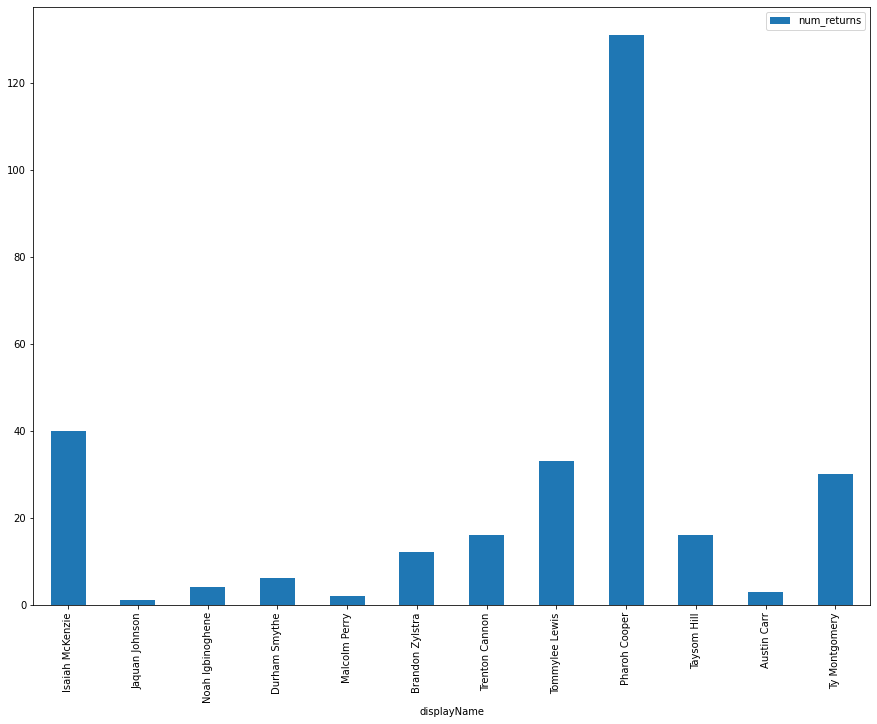

In [48]:
returners.head(12).plot.bar(x='displayName', y='num_returns')

## *TO BE CONTINUED....*